# Libraries importing

In [1]:
import math
import os
import pickle
import sys

import catboost
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import missingno
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import BaggingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

print('Python:'.ljust(16), sys.version.split('\n')[0])
print('Scikit-learn:'.ljust(16), sklearn.__version__)
print('CatBoost:'.ljust(16), catboost.__version__)

Python:          3.10.9 (v3.10.9:1dd9be6584, Dec  6 2022, 14:37:36) [Clang 13.0.0 (clang-1300.0.29.30)]
Scikit-learn:    1.3.0
CatBoost:        1.2


In [2]:
# Save requirements
!pip freeze > requirements.txt

# Constants definition

In [3]:
DATA_PATH = './data/'
MODELS_PATH = './models/'
CACHE_MODELS = True
RANDOM_STATE = 424242

# Feature to separate training and validation parts
TRAIN = 'TRAIN'

# Dataset loading

In [4]:
# Read training dataframe
df_train = pd.read_csv(DATA_PATH + 'NBKI_train.csv', index_col=0)
df_train[TRAIN] = True

# Read validation dataframe
x_valid = pd.read_csv(DATA_PATH + 'NBKI_test.csv', index_col=0)
y_valid = pd.read_csv(DATA_PATH + 'NBKI_y_test.csv', index_col=0)
df_valid = x_valid.join(y_valid)
df_valid[TRAIN] = False

# Append validation and training dataframes
df = pd.concat([df_train, df_valid])

# Add index to separate column
df.reset_index(inplace=True)

del df_train, df_valid, x_valid, y_valid
df

,index,0,1,2,3,4,5,6,7,8,...,125,126,127,128,129,130,131,132,default,TRAIN
0,48417,9,1,0,22,10,500000.0,75.0,75.0,3262,...,0,13,1096,0.125000,0.000000,0.011628,0.032787,1,0.0,True
1,109120,9,1,5,13,10,29983.0,22.0,22.0,2189,...,0,3,123,0.181818,0.250000,0.020408,0.000000,1,0.0,True
2,232425,9,1,0,15,10,730000.0,16.0,16.0,2863,...,0,5,1826,0.222222,0.000000,0.029851,0.000000,1,0.0,True
3,31393,7,1,0,8,10,0.0,68.0,68.0,6,...,0,0,498,0.000000,0.000000,0.000000,0.000000,0,1.0,True
4,47064,1,1,0,22,10,901484.0,63.0,63.0,3708,...,0,16,182,0.086957,0.000000,0.008734,0.023810,1,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,584701,7,1,6,18,11,79483.0,66.0,6.0,254,...,0,0,29628,0.000000,0.000000,0.000000,0.000000,1,0.0,False
59996,402816,7,1,3,29,11,27000.0,6.0,74.0,426,...,0,0,1827,0.333333,0.000000,0.105263,0.117647,1,0.0,False
59997,512248,7,1,0,19,11,45000.0,72.0,72.0,1836,...,0,9,29628,0.470588,1.000000,0.111765,0.238095,1,0.0,False
59998,505324,9,1,3,15,11,10883.0,25.0,25.0,3258,...,0,1,364,0.333333,0.000000,0.013889,0.000000,1,0.0,False


Make a deep copy of the dataframe to use it with linear ML methods. Trees based methods are not sensitive to outliers, linear dependense and some of theese can work with missing values.

In [5]:
# Make a deep copy of the dataframe to use it with linear ML methods
df_linear_ml = df.copy()

# Exploratory data analysis
## General info

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 136 entries, index to TRAIN
dtypes: bool(1), float64(11), int64(124)
memory usage: 61.9 MB


In [7]:
print('Number of unique indices:', df['index'].nunique())

Number of unique indices: 60000


In [8]:
print('Number of training objects:  ', len(df.loc[df[TRAIN]]))
print('Number of validation objects:', len(df.loc[~df[TRAIN]]))

Number of training objects:   30007
Number of validation objects: 29993


In [9]:
print('Number of defaults in training sample:  ', len(df.loc[df[TRAIN] & df['default'] == 1]))
print('Number of defaults in validation sample:', len(df.loc[~df[TRAIN] & df['default'] == 1]))

Number of defaults in training sample:   1000
Number of defaults in validation sample: 938


## Correlation analysis
### Correlation matrix

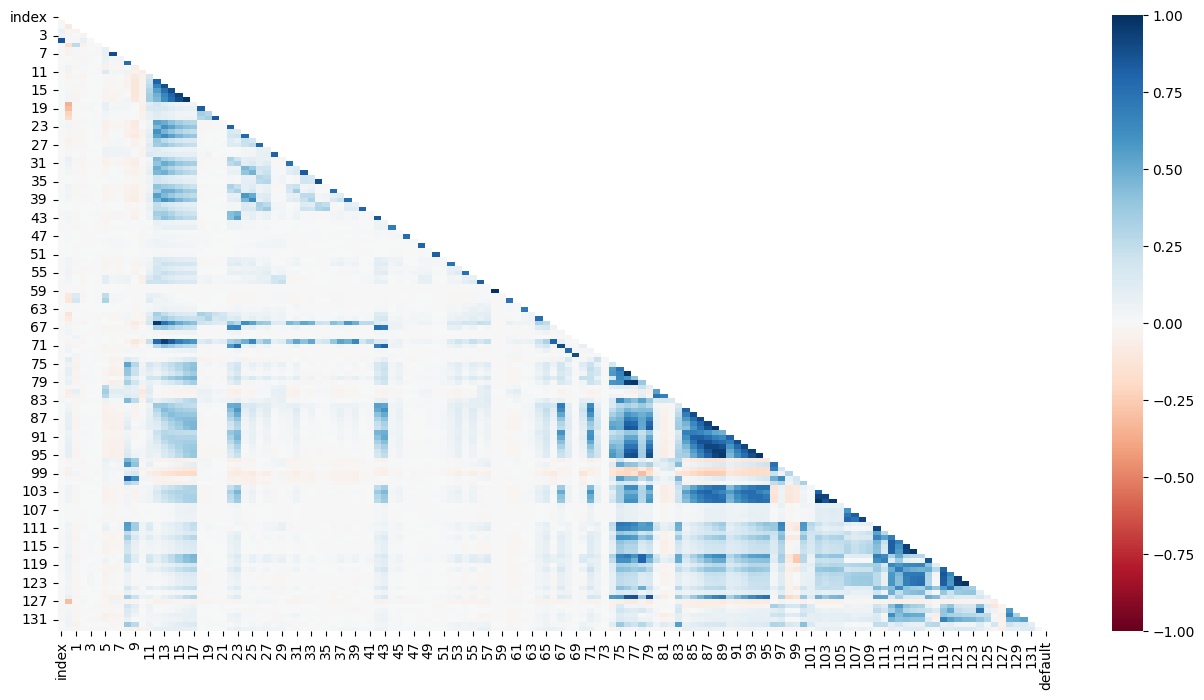

In [10]:
# Compute correlation table
corr = df.drop(columns=TRAIN).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.subplots(figsize=(16, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, cmap="RdBu");

### Correlation with target

In [11]:
# Sort absolute correlation values with target variable
corr['default'].abs().sort_values(ascending=False)

default    1.000000
119        0.157898
121        0.156446
131        0.152586
122        0.149154
             ...   
58         0.000746
72         0.000515
99         0.000474
21         0.000292
97         0.000011
Name: default, Length: 135, dtype: float64

### Correlation with index

In [12]:
# Show correlation whit column 'index'
corr['index'].abs().sort_values(ascending=False).head(3)

index    1.000000
4        0.865791
2        0.068284
Name: index, dtype: float64

### Searching for strong correlations

In [13]:
# Correlation threshold
corr_threshold = 0.95

# Triangle mask
triangle_mask = np.triu(np.ones_like(corr, dtype=bool))

# Mask correlations below threshold value
corr_mask = corr.mask(triangle_mask).where(corr.abs() > corr_threshold)

# Show onle strong correlations
strong_corr = corr_mask.dropna(axis=0, how='all').dropna(axis=1, how='all')
strong_corr

,12,16,58,76,77,88,89,94,102,104,115,121,122
17,NaN,0.977553,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,0.957182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,NaN,NaN,NaN,0.980146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,NaN,NaN,0.969059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,NaN,NaN,NaN,NaN,NaN,0.971765,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94,NaN,NaN,NaN,NaN,NaN,0.952917,0.950281,NaN,NaN,NaN,NaN,NaN,NaN
95,NaN,NaN,NaN,NaN,NaN,NaN,0.962581,0.9711,NaN,NaN,NaN,NaN,NaN
105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.97765,0.968865,NaN,NaN,NaN
116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.974532,NaN,NaN


In [14]:
# Sort strong correlations with target
strong_corr_cols = list(set(strong_corr.index.to_list() + strong_corr.columns.to_list()))
corr.loc[strong_corr_cols, 'default'].abs().sort_values(ascending=False)

121    0.156446
122    0.149154
123    0.145507
115    0.133130
116    0.132655
104    0.081692
12     0.080736
16     0.080019
17     0.074270
105    0.071988
66     0.068444
102    0.068269
88     0.051298
89     0.039607
94     0.038228
95     0.028827
76     0.021042
77     0.009443
79     0.002618
58     0.000746
59     0.000746
Name: default, dtype: float64

### Removing of strong correlations

In [15]:
df.drop(columns='58', inplace=True)
df_linear_ml.drop(columns=['17', '58', '66', '77', '79', '89', '94', '95', '102', '105', '116', '122', '123'], inplace=True)

## Missing values
### Showing of missing values

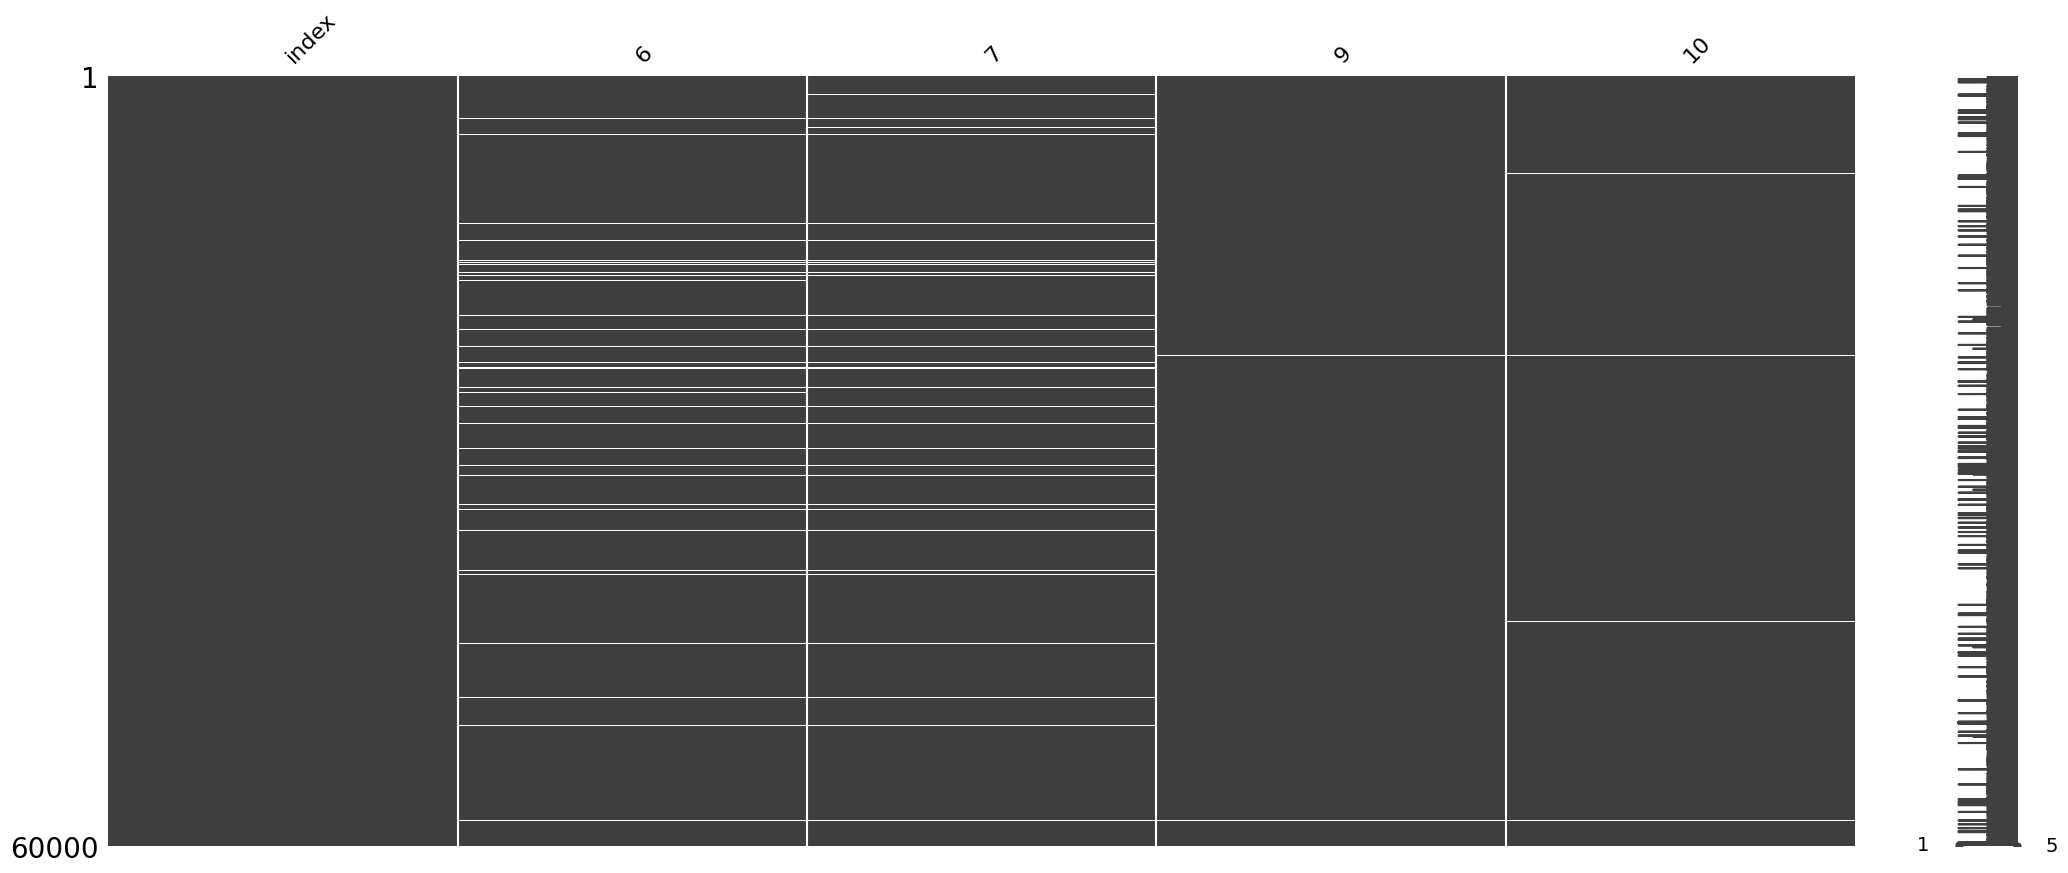

In [16]:
missingno.matrix(df, filter='bottom', n=5);

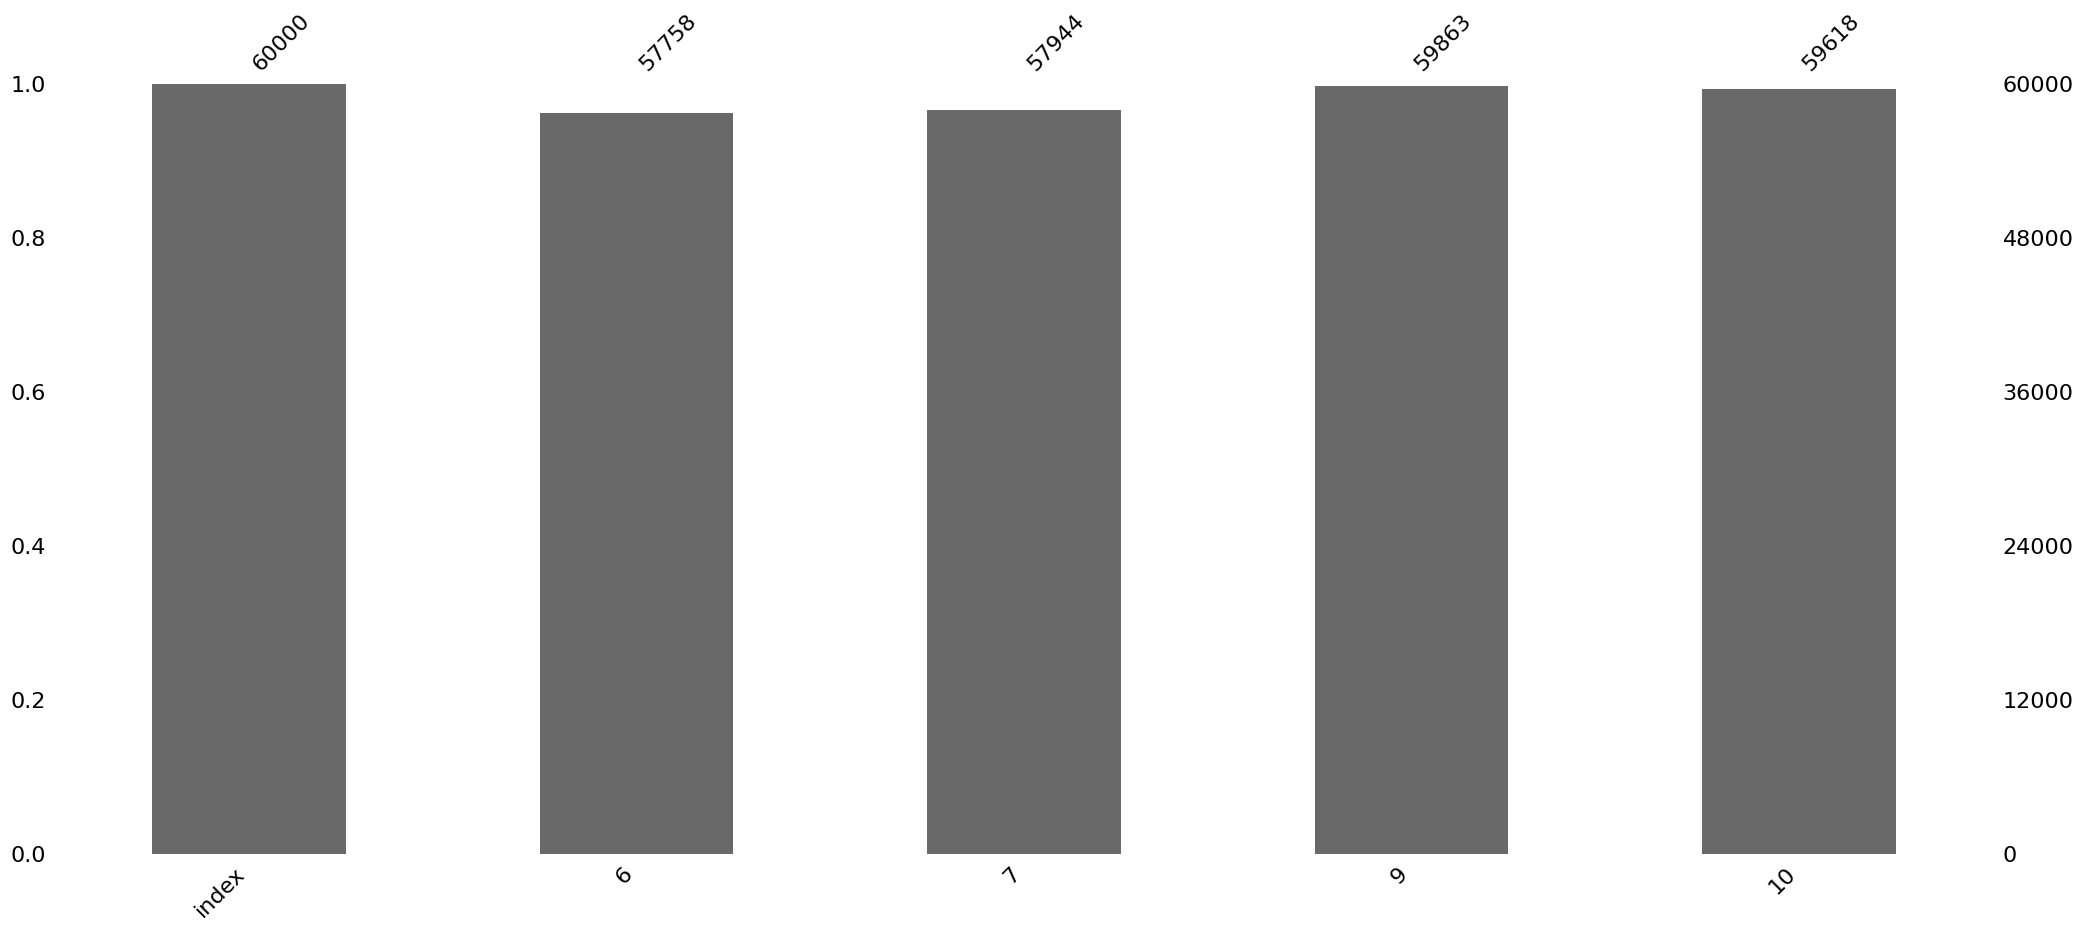

In [17]:
missingno.bar(df, filter='bottom', n=5);

### Correlation with columns that contain missing values

In [18]:
# Show correlation whit column '6'
corr['6'].abs().sort_values(ascending=False).head(3)

6     1.000000
7     0.891104
81    0.111332
Name: 6, dtype: float64

In [19]:
# Show correlation whit column '7'
corr['7'].abs().sort_values(ascending=False).head(3)

7     1.000000
6     0.891104
81    0.110228
Name: 7, dtype: float64

In [20]:
# Show correlation whit column '9'
corr['9'].abs().sort_values(ascending=False).head(3)

9      1.000000
8      0.761845
100    0.613213
Name: 9, dtype: float64

In [21]:
# Show correlation whit column '10'
corr['10'].abs().sort_values(ascending=False).head(3)

10    1.000000
81    0.094005
82    0.073990
Name: 10, dtype: float64

In [22]:
df.loc[df['6'].isna(), ['6', '7']]

,6,7
47,NaN,13.0
89,NaN,NaN
169,NaN,NaN
185,NaN,NaN
224,NaN,NaN
...,...,...
59627,NaN,NaN
59723,NaN,NaN
59809,NaN,NaN
59899,NaN,NaN


In [23]:
df.loc[df['9'].isna(), ['8', '9']]

,8,9
249,-2,NaN
422,-2,NaN
486,-4,NaN
1448,-335,NaN
1518,-3,NaN
...,...,...
58858,-3,NaN
58914,-5,NaN
59526,-150,NaN
59723,-417,NaN


### Historgrams and scatters of correlated columns with missing values

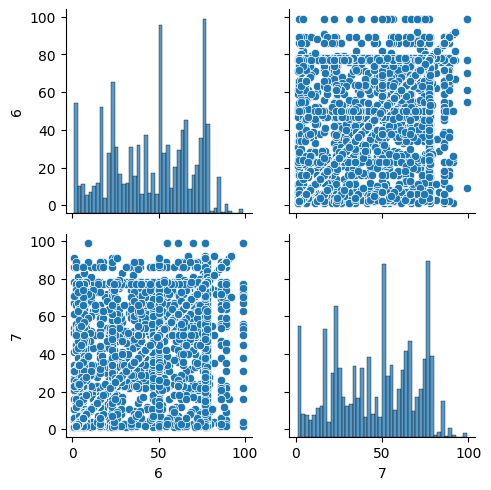

In [24]:
g = sns.PairGrid(df[['6', '7']])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot);

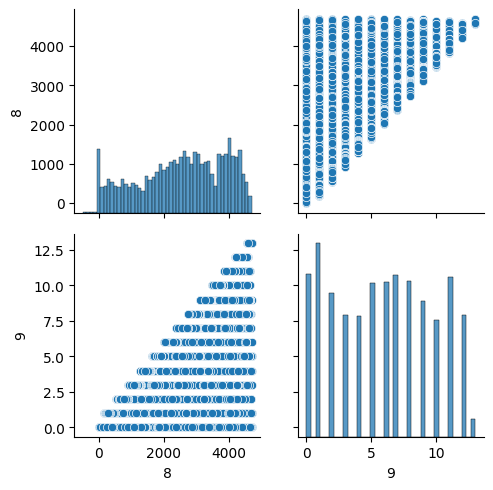

In [25]:
g = sns.PairGrid(df[['8', '9']])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot);

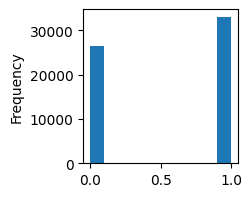

In [26]:
df['10'].plot(kind='hist', figsize=(2, 2));

### Adding of columns that indicate missing values

In [27]:
# Create columns
df_linear_ml['6_nan'] = 0
df_linear_ml['7_nan'] = 0
df_linear_ml['10_nan'] = 0

# Write ones that correspond to missing values
df_linear_ml.loc[df_linear_ml['6'].isna(), '6_nan'] = 1
df_linear_ml.loc[df_linear_ml['7'].isna(), '7_nan'] = 1
df_linear_ml.loc[df_linear_ml['10'].isna(), '10_nan'] = 1

There is no need to create a column for '9' feature because I will replace missing values for that column with unique value -1 

### Filling of missing values

In [28]:
df_linear_ml['6'].fillna(df_linear_ml['6'].mean(), inplace=True)
df_linear_ml['7'].fillna(df_linear_ml['7'].mean(), inplace=True)
df_linear_ml['10'].fillna(df_linear_ml['10'].mode()[0], inplace=True)

# Fill missing values for column '9' for both dataframes
df['9'].fillna(-1, inplace=True)
df_linear_ml['9'].fillna(-1, inplace=True)

## Outliers
### Showing of boxplots

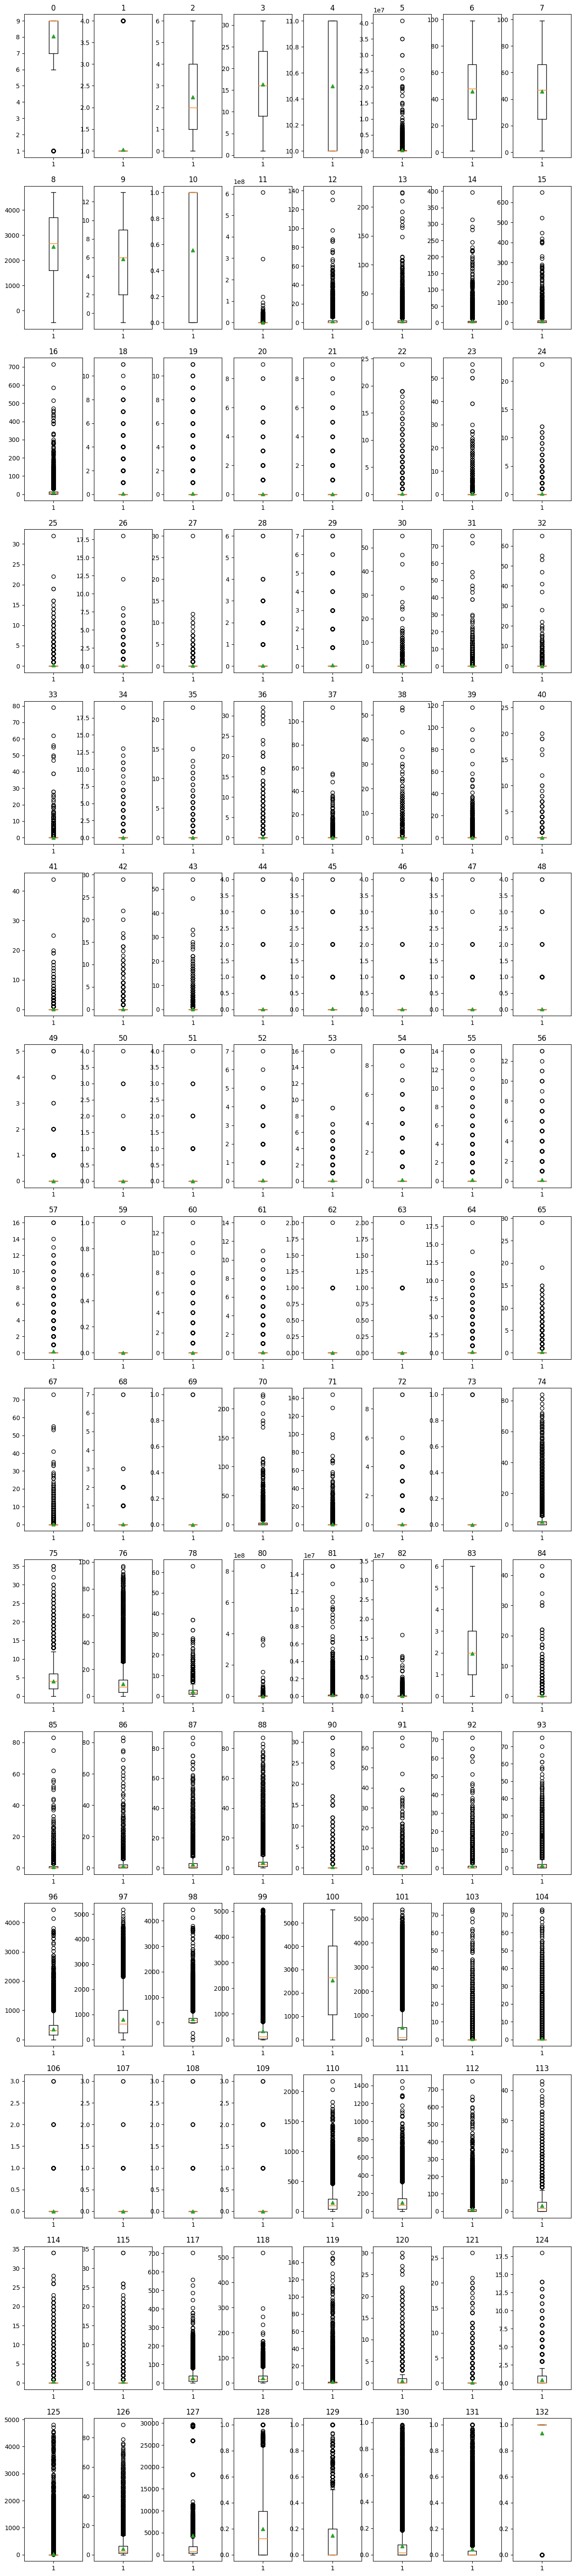

In [29]:
# Define columns to plot
df_columns = set(df_linear_ml.columns.to_list())
plot_columns = [str(i) for i in range(133) if str(i) in df_columns]

# Create figure with [rows x cols] graphs
cols = 8
rows = math.ceil((len(plot_columns)) / cols)
fig, axs = plt.subplots(rows, cols, figsize=(16, rows*5))

# Plot graphs
for i, column in enumerate(plot_columns):
    if rows == 1:
        idx = i%cols
    else:
        idx = (i//cols, i%cols)
    axs[idx].boxplot(df_linear_ml.loc[df_linear_ml[column].notna(), column], showmeans=True)
    axs[idx].set_title(column)

In [30]:
outliers = {}
outliers_num = {}
for column in plot_columns:
    # Calculate Q1, Q3, IQR
    Q1 = df_linear_ml[column].quantile(0.25)
    Q3 = df_linear_ml[column].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate indices of rows
    outliers[column] = list(df_linear_ml.loc[(~df_linear_ml[column].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR))
                            & (df_linear_ml[column].notna()), column].index)
    outliers_num[column] = len(outliers[column])

print('Number of outliers per column:')
pd.Series(outliers_num)

Number of outliers per column:


0      1325
1       550
2         0
3         0
4         0
       ... 
128    1536
129    5385
130    6405
131    9510
132    3849
Length: 120, dtype: int64

# Data splitting & scaling
## For tree based models

In [31]:
# Split data
x = df.drop(columns=[TRAIN, 'default'])
y = df['default']
x_train = df.loc[df[TRAIN], :].drop(columns=[TRAIN, 'default'])
x_valid = df.loc[~df[TRAIN], :].drop(columns=[TRAIN, 'default'])
y_train = df.loc[df[TRAIN], 'default']
y_valid = df.loc[~df[TRAIN], 'default']

# Print data shape
print('Shapes:', x.shape, x_train.shape, x_valid.shape, y.shape, y_train.shape, y_valid.shape)

Shapes: (60000, 133) (30007, 133) (29993, 133) (60000,) (30007,) (29993,)


## For linear models

In [32]:
# Split data
x_linear = df_linear_ml.drop(columns=[TRAIN, 'default'])
y_linear = df_linear_ml['default']
x_train_linear = df_linear_ml.loc[df_linear_ml[TRAIN], :].drop(columns=[TRAIN, 'default'])
x_valid_linear = df_linear_ml.loc[~df_linear_ml[TRAIN], :].drop(columns=[TRAIN, 'default'])
y_train_linear = df_linear_ml.loc[df_linear_ml[TRAIN], 'default']
y_valid_linear = df_linear_ml.loc[~df_linear_ml[TRAIN], 'default']

# Scale data
scaler = StandardScaler()
x_linear = pd.DataFrame(scaler.fit_transform(x_linear), columns=x_linear.columns)
x_train_linear = pd.DataFrame(scaler.transform(x_train_linear), columns=x_train_linear.columns)
x_valid_linear = pd.DataFrame(scaler.transform(x_valid_linear), columns=x_valid_linear.columns)

# Print data shape
print('Shapes:', x_linear.shape, x_train_linear.shape, x_valid_linear.shape,
      y_linear.shape, y_train_linear.shape, y_valid_linear.shape)

Shapes: (60000, 124) (30007, 124) (29993, 124) (60000,) (30007,) (29993,)


# Dummy Classifier

In [33]:
def predict_eval(model, x_train, y_train, x_valid, y_valid):
    pred_train = model.predict(x_train)
    pred_valid = model.predict(x_valid)
    
    accuracy_train = accuracy_score(y_train, pred_train)
    accuracy_valid = accuracy_score(y_valid, pred_valid)
    
    f1_train = f1_score(y_train, pred_train)
    f1_valid = f1_score(y_valid, pred_valid)
    
    print(f'Training accuracy:   {(accuracy_train*100):.4f} %')
    print(f'Validation accuracy: {(accuracy_valid*100):.4f} %')
    print()
    print(f'Training F1 score:   {(f1_train*100):.4f} %')
    print(f'Validation F1 score: {(f1_valid*100):.4f} %')

    return accuracy_train, accuracy_valid, f1_train, f1_valid

In [34]:
# Define model
model = DummyClassifier(strategy='constant', constant=0, random_state=RANDOM_STATE)
model.fit(x_train, y_train)

# Predict and evaluate
predict_eval(model, x_train, y_train, x_valid, y_valid);

Training accuracy:   96.6674 %
Validation accuracy: 96.8726 %

Training F1 score:   0.0000 %
Validation F1 score: 0.0000 %


# Decision Tree Classifier
## Fit

In [35]:
%%time
model_file = MODELS_PATH + 'decision_tree.pickle'

# Load model if it already exists or train it otherwise
if CACHE_MODELS and os.path.isfile(model_file):
    with open(model_file, 'rb') as f:
        model = pickle.load(f)
else:
    model = DecisionTreeClassifier(criterion='gini', random_state=RANDOM_STATE)
    model.fit(x_train, y_train)

# Save model
if CACHE_MODELS:
    with open(model_file, 'wb') as f:
        pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 534 ms, sys: 7.93 ms, total: 542 ms
Wall time: 541 ms


## Predict and evaluate

In [36]:
predict_eval(model, x_train, y_train, x_valid, y_valid);

Training accuracy:   97.1907 %
Validation accuracy: 95.4389 %

Training F1 score:   27.2649 %
Validation F1 score: 7.3171 %


# Bagging Classifier
## Fit

In [37]:
%%time
model_file = MODELS_PATH + 'bagging.pickle'

# Load model if it already exists or train it otherwise
if CACHE_MODELS and os.path.isfile(model_file):
    with open(model_file, 'rb') as f:
        model = pickle.load(f)
else:
    model = BaggingClassifier(n_estimators=10, bootstrap=True, n_jobs=-1, random_state=RANDOM_STATE)
    model.fit(x_train, y_train)

# Save model
if CACHE_MODELS:
    with open(model_file, 'wb') as f:
        pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 35.2 ms, sys: 82.5 ms, total: 118 ms
Wall time: 1.92 s


## Predict and evaluate

In [38]:
predict_eval(model, x_train, y_train, x_valid, y_valid);

Training accuracy:   97.1207 %
Validation accuracy: 96.9793 %

Training F1 score:   23.9437 %
Validation F1 score: 7.9268 %


# Histogram-based Gradient Boosting Classifier
## Fit

In [39]:
%%time
model_file = MODELS_PATH + 'histogram_gb.pickle'

# Load model if it already exists or train it otherwise
if CACHE_MODELS and os.path.isfile(model_file):
    with open(model_file, 'rb') as f:
        model = pickle.load(f)
else:
    model = HistGradientBoostingClassifier(max_iter=100, random_state=RANDOM_STATE)
    model.fit(x_train, y_train)

# Save model
if CACHE_MODELS:
    with open(model_file, 'wb') as f:
        pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 5.6 s, sys: 1.34 s, total: 6.94 s
Wall time: 1.04 s


## Predict and evaluate

In [40]:
predict_eval(model, x_train, y_train, x_valid, y_valid);

Training accuracy:   97.9671 %
Validation accuracy: 96.9426 %

Training F1 score:   56.4907 %
Validation F1 score: 13.8967 %


# CatBoost Classifier
## Fit

In [41]:
%%time
model_file = MODELS_PATH + 'catboost' + '.cbm'

# Load model if it already exists or train it otherwise
if CACHE_MODELS and os.path.isfile(model_file):
    model = CatBoostClassifier()
    model.load_model(model_file)
else:
    model = CatBoostClassifier(iterations=1000,
                               depth=2,
                               learning_rate=1,
                               loss_function='Logloss',
                               verbose=False)
    model.fit(x_train, y_train)

# Save model
if CACHE_MODELS:
    model.save_model(model_file)

CPU times: user 18.5 s, sys: 3.49 s, total: 22 s
Wall time: 4.54 s


## Predict and evaluate

In [42]:
predict_eval(model, x_train, y_train, x_valid, y_valid);

Training accuracy:   99.1702 %
Validation accuracy: 95.7623 %

Training F1 score:   85.8281 %
Validation F1 score: 24.2099 %


# Pipeline
## Prepare dataframe

In [43]:
x_text = pd.read_csv(DATA_PATH + 'NBKI_test.csv', index_col=0)
x_text.reset_index(inplace=True)
x_text.drop(columns='58', inplace=True)
x_text['9'].fillna(-1, inplace=True)

## Load model

In [44]:
model_file = MODELS_PATH + 'catboost' + '.cbm'
model = CatBoostClassifier()
model.load_model(model_file);

## Predict

In [45]:
result = model.predict(x_text, 'Class')
result

array([0., 1., 0., ..., 0., 0., 0.])